In [17]:
import comet_ml
from comet_ml.query import Parameter
import pandas as pd
import numpy as np
import datetime
from statistics import mean

In [18]:
comet_api = comet_ml.api.API()
fedavg_query = (Parameter('SERVER_OPT') == "SGD") & (Parameter('SERVER_OPT_MOMENTUM') == None)
fedavgm_query = Parameter('SERVER_OPT_MOMENTUM') != None
fedadam_query = Parameter('SERVER_OPT') == "Adam"
fedadagrad_query = Parameter('SERVER_OPT') == "Adagrad"

def get_exps(query):
    return comet_api.query('federated-learning', 'server-side-opt-long', query)

fedavg_exps = get_exps(fedavg_query)
fedavgm_exps = get_exps(fedavgm_query)
fedadam_exps = get_exps(fedadam_query)
fedadagrad_exps = get_exps(fedadagrad_query)

In [19]:
def get_df(exps):
    teas = [float(exp.get_metrics_summary('test_acc')['valueMax']) for exp in exps]
    ids = [exp.name for exp in exps]
    dt = [datetime.datetime.fromtimestamp(exp.get_metadata()['endTimeMillis']/1000.0) for exp in exps]
    tea_avgs = [avg_acc_last_100(exp) for exp in exps]
    return pd.DataFrame({'id': ids, 'test_acc': teas, 'test_acc avg last 100': tea_avgs, 'dt': dt})

def avg_acc_last_100(exp):
    dict_acc = exp.get_metrics('test_acc')
    value = [float(record['metricValue']) for record in dict_acc]
    return mean(value[-100:])

In [20]:
fedadam_df = get_df(fedadam_exps)
fedavg_df = get_df(fedavg_exps)
fedavgm_df = get_df(fedavgm_exps)
fedadagrad_df = get_df(fedadagrad_exps)

In [21]:
def group_by_date(df):
    on = 'test_acc avg last 100'
    sampled = df.resample('H', on='dt').max()[[on]].join(df[['id', on]].set_index(on), on=on, lsuffix='_caller', rsuffix='_other').fillna(method='ffill')
    for i in range(len(sampled)-1):
        if sampled.iloc[i][on] > sampled.iloc[i+1][on]:
            sampled.iloc[i+1] = sampled.iloc[i]
    return sampled

In [22]:
fedadam_df_gr = group_by_date(fedadam_df)
fedavg_df_gr = group_by_date(fedavg_df)
fedavgm_df_gr = group_by_date(fedavgm_df)
fedadagrad_df_gr = group_by_date(fedadagrad_df)

In [23]:
fedadam_df_gr['opt'] = 'Adam'
fedavg_df_gr['opt'] = 'Avg'
fedavgm_df_gr['opt'] = 'AvgM'
fedadagrad_df_gr['opt'] = 'Adagrad'

df = pd.concat([fedadam_df_gr, fedavg_df_gr, fedavgm_df_gr, fedadagrad_df_gr])

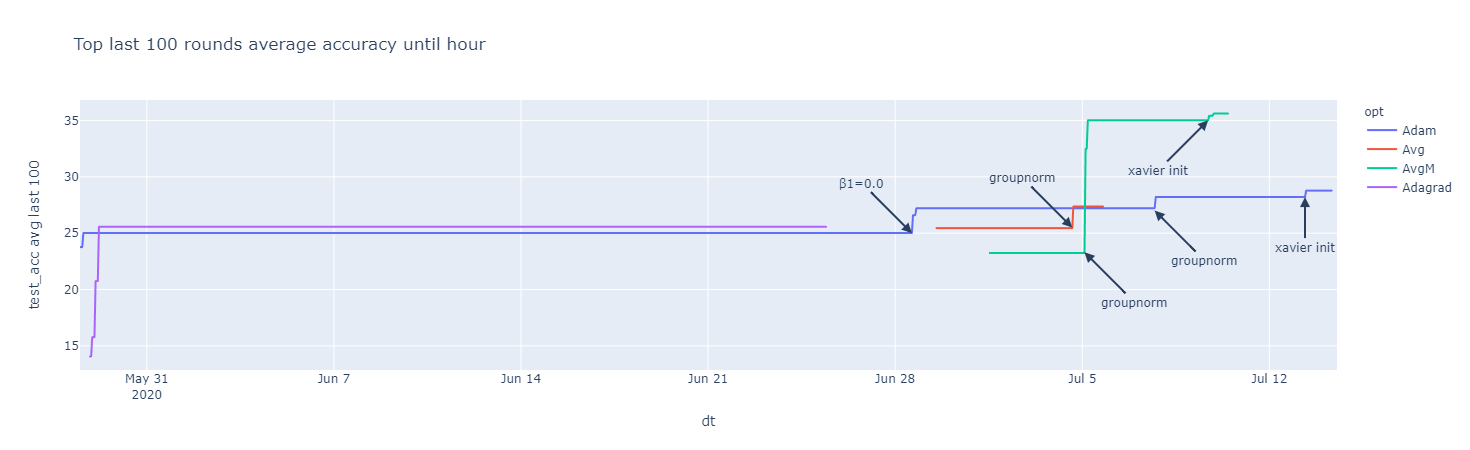

In [52]:
import plotly.express as px

# fig = px.line(df, y="test_acc", color='opt', title="Top last accuracy until day")
# fig.show()

#[df.index > datetime.datetime(year=2020, month=6, day=27)]
fig = px.line(df, y="test_acc avg last 100", color='opt', title="Top last 100 rounds average accuracy until hour", hover_name='id') #, width=1200, height=400)

adam_not = [("β1=0.0",      datetime.datetime(year=2020, month=6, day=28, hour=15), 25,  -50, -50),
            ("groupnorm",   datetime.datetime(year=2020, month=7, day=7, hour=17),  27,   50,  50),
            ("xavier init", datetime.datetime(year=2020, month=7, day=13, hour=8),  28.2,  0,  50)]

avg_not = [("groupnorm", datetime.datetime(year=2020, month=7, day=4, hour=15), 25.5, -50, -50)]

avgm_not = [("groupnorm",   datetime.datetime(year=2020, month=7, day=5, hour=2),  23.3, 50,  50),
            ("xavier init", datetime.datetime(year=2020, month=7, day=9, hour=17), 35,   -50, 50)]

for t, d, acc, ax, ay in adam_not + avg_not + avgm_not:
    fig.add_annotation(
            x=d,
            y=acc,
            text=t,
            showarrow=True,
            arrowhead=2,
            arrowwidth=2,
            ax=ax,
            ay=ay,
            )
fig.show()
# fig.write_image("avg100.svg")

In [49]:
df.index > datetime.datetime(year=2020, month=6, day=27)

array([False, False, False, ..., False, False, False])

In [25]:
from IPython.core.display import HTML, display
on = 'test_acc avg last 100'
prev = (None, None)
for i in range(len(fedadam_df_gr) - 24):
    today = fedadam_df_gr.iloc[i]
    tomorrow = fedadam_df_gr.iloc[i+24]
    if (today[on] < tomorrow[on]) and (prev[0] != today.id) and (prev[1] != tomorrow.id):
        display(HTML(fr'<a href="https://www.comet.ml/federated-learning/server-side-opt-long/{today.id}/{tomorrow.id}/compare?experiment-tab=params">{tomorrow[on] - today[on]}</a>'))
        prev = (today.id, tomorrow.id)

In [26]:
def get_params_dict(exp):
    params_summ = exp.get_parameters_summary()
    res = {ps['name']: ps['valueCurrent'] for ps in params_summ}
    res['fixed output'] = 'fixed output' in exp.get_tags()
    return res

def get_params_dict_diff(params_dict, params_dict2):
    return set(params_dict.items()) ^ set(params_dict2.items())

In [27]:
def list_params_change(exps):
    ignored_params = ['CLIENT_LEARNING_RATE', 'SERVER_LEARNING_RATE', 'curr_round', 'curr_step', 'TOTAL_EPOCH', 'BREAK_ROUND', 'TARGET_ACC', 'BATCH_SIZE', 'CLIENT_FRACTION', 'DL_N_WORKER', 'IS_IID_DATA', 'N_CLIENTS', 'SEED']

    current_params = get_params_dict(exps[0])
    for k in ignored_params:
        if k in current_params.keys():
            del current_params[k]
    df = pd.DataFrame(columns=['exp_id', 'test_acc'])
    df = df.append(current_params, ignore_index=True)
    max_acc = 0
    best_exp_id = None
    for exp in exps[1:]:
        change_list = {}
        new_params = get_params_dict(exp)
        
        diff = get_params_dict_diff(new_params, current_params)
        for k, v in diff:
            if (k not in ignored_params) and ((k not in current_params.keys()) or (current_params[k] != v)):
                change_list[k] = v
        if len(change_list) != 0:
            df.loc[df.index[-1], 'exp_id'] = best_exp_id
            df.loc[df.index[-1], 'test_acc'] = max_acc
            max_acc = 0
            best_exp_id = None
            
            change_list['date'] = datetime.datetime.fromtimestamp(exp.get_metadata()['endTimeMillis']/1000.0)
            for k, v in change_list.items():
                current_params[k] = v
            df = df.append(change_list, ignore_index=True)
            
        new_acc = avg_acc_last_100(exp)
        if new_acc > max_acc:
            max_acc = new_acc
            best_exp_id = exp.id

    df.loc[df.index[-1], 'exp_id'] = best_exp_id
    df.loc[df.index[-1], 'test_acc'] = max_acc
    return df.fillna("")

In [28]:
list_params_change(fedavg_exps)

,exp_id,test_acc,CLIENT_OPT,CLIENT_OPT_STRATEGY,MAX_ROUNDS,N_EPOCH_PER_CLIENT,SERVER_OPT,fixed output,NORM,date,INIT
0,daa89f9cda2746a0b890486af24afb31,16.6528,SGD,reinit,1500,1,SGD,0,,,
1,97f75d111ac145488e780d634b62688b,27.3601,,,,,,,group,2020-07-04 13:40:47.209000,
2,d3fb5daec45c43c6a0f9f686de3ea84c,16.3799,,,,,,,,2020-07-05 19:37:30.261000,keras


In [29]:
list_params_change(fedavgm_exps)

,exp_id,test_acc,CLIENT_OPT,CLIENT_OPT_STRATEGY,MAX_ROUNDS,N_EPOCH_PER_CLIENT,SERVER_OPT,SERVER_OPT_MOMENTUM,fixed output,NORM,date,INIT,IMAGE_NORM
0,2fd0360140664ff5b34f9b6cf98db084,22.4515,SGD,reinit,1500,1,SGD,0.9,0,,,,
1,50244ece13bb439fadd499b6a91bc1b3,35.0138,,,,,,,,group,2020-07-05 00:23:34.016000,,
2,d93c747923444c8f88a379c34d2923e7,35.4172,,,,,,,1,,2020-07-09 18:14:30.640000,keras,
3,3eaace412df5447db5eb5b9e7daabdcc,35.6171,,,,,,,,,2020-07-09 22:42:50.947000,null,
4,11e620ea7fa04f7698ef396153f33ef0,30.4976,,,,,,,,,2020-07-10 05:50:01.198000,,tflike
5,7a806387547e4dcf875f86e3ac2f1d97,1.0063,,,,,,,,,2020-07-10 11:55:35.794000,keras,


In [30]:
list_params_change(fedadam_exps)

,exp_id,test_acc,CLIENT_OPT,CLIENT_OPT_STRATEGY,MAX_ROUNDS,N_EPOCH_PER_CLIENT,SERVER_OPT,fixed output,SERVER_OPT_ARGS,date,INIT,NORM,SERVER_OPT_BETAS_0,SERVER_OPT_BETAS_1,SERVER_OPT_EPS,IMAGE_NORM
0,c2312cf08a4c4af1b69675f921adeffa,25.0101,SGD,reinit,1500,1,Adam,0,,,,,,,,
1,b674427d82754cd9ada371e3f76b9538,27.2145,,,,,,,"[""betas""]",2020-06-28 16:20:19.372000,,,,,,
2,80f809d9ceec4da19308306ceba1f8cb,28.2046,,,,,,1,,2020-07-05 23:11:56.930000,null,group,0.0,0.99,0.01,
3,40909b0858414b6abbca2dcf0ce4149a,1.0017,,,,,,,,2020-07-10 23:26:28.149000,keras,,,,,tflike
4,e1c173dd7fdc4b139c67b0bf97c81554,8.1742,,,,,,0,,2020-07-13 00:30:49.872000,,,,,,thlike
5,d242f7220c0c4c638eb0244707fb9002,4.2406,,,,,,,,2020-07-13 06:33:29.987000,,,,,,tflike
6,d2635bcab6b744f78b264a4b5c9cebd6,28.7697,,,,,,,,2020-07-13 09:41:48.654000,,,,,,thlike
7,0e79a1cd545d4140b4aa40466f9a1d83,23.2844,,,,,,,,2020-07-13 12:49:48.436000,,,,,,tflike


In [31]:
list_params_change(fedadagrad_exps)

,exp_id,test_acc,CLIENT_OPT,CLIENT_OPT_STRATEGY,MAX_ROUNDS,N_EPOCH_PER_CLIENT,SERVER_OPT,fixed output
0,8d43b23f425447f9a0de0cb985b1caa5,25.566,SGD,reinit,1500,1,Adagrad,0.0
